# Probabilistic Linear Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ChemAI-Lab/AI4Chem/blob/main/website/modules/01-probabilistic_linear_models.ipynb)


**References:**
1. **Chapters 3**: [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), C. M. Bishop.
2. **Chapter 2**:  [Gaussian Processes for Machine LearningOpen Access](https://direct.mit.edu/books/oa-monograph-pdf/2514321/book_9780262256834.pdf), C. E. Rasmussen, C. K. I. Williams

In [ ]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import matplotlib
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider

# Bayesian Regression

So far we have considered linear models of the form,
$$
f(\mathbf{\phi}(\mathbf{x}),\mathbf{w}) = \mathbf{w}^\top \mathbf{\phi}(\mathbf{x})= \sum_{i}^d w_i \, \phi_i(\mathbf{x}),
$$
where the parameters $\mathbf{w}$ are optimized either through, 
1. Mean Square Error function,
   $$
    {\cal L}(\mathbf{w}) = \|\mathbf{y} - \Phi(\mathbf{X})\mathbf{w} \|_2^2  = \frac{1}{2n}\sum_{i}^{n} (\hat{y}_i - \mathbf{w}^\top\phi(\mathbf{x}_i))^2 
    $$
2. Ridge Regression function
    $$
    {\cal L}(\mathbf{w}) = \|\mathbf{y} - \Phi(\mathbf{X})\mathbf{w} \|_2^2 + \lambda \|\mathbf{w}\|_2^2 = \frac{1}{2n}\sum_{i}^{n} (\hat{y}_i - \mathbf{w}^\top\phi(\mathbf{x}_i))^2 + \lambda \sum_j^d w_j^2
    $$

For both methods procedure a single best-fit line, but provides no notion of uncertainty or noise.
So far, we treated $\mathbf{w}$ as an unknown but fixed parameter, meaning it has a well determined value.
One could argue that this should not be the case, and $\mathbf{w}$ could be parameterized by a probability distribution. <br>


# Bayesian Regression

In Bayesian Regression we aim to find the distribution of the model's parameters condition on some data or information. For this we will use Bayes's rule
$$
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \propto p(\mathbf{y}|\mathbf{w}, \mathbf{X}) p(\mathbf{w}),
$$
where
* $p(\mathbf{y}|\mathbf{w}, \mathbf{X})$ is the **likelihood**
* $p(\mathbf{w})$ is the **prior**

## Likelihood of the Data
Under the Gaussian noise assumption, the conditional distribution of each observation is
$$
p(y_i|\mathbf{w}, \mathbf{x}_i) = {\cal N}(y_i|\mathbf{w}^\top\mathbf{x}_i, \sigma^2).
$$
Assuming i.i.d. data, the likelihood of the full dataset is
$$
p(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_i^N p(y_i|\mathbf{w}, \mathbf{x}_i) = \prod_i^N {\cal N}(y_i|\mathbf{w}^\top\mathbf{x}_i, \sigma^2).
$$

Taking the logarithm of the likelihood gives, 
$$
\log p(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \frac{N}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_i^N \left ( y_i - \mathbf{w}^\top\mathbf{x}_i \right )^2.
$$
Besides the constants, $\log p(\mathbf{y}|\mathbf{w}, \mathbf{X})$ is the same error function as the MSE.

$$
\arg\max_{\mathbf{w}}\, \log p(\mathbf{y}|\mathbf{w}, \mathbf{X}) \Longleftrightarrow\, \arg\min_{\mathbf{w}} \frac{1}{2N} \sum_i^N \left ( y_i - \mathbf{w}^\top\mathbf{x}_i \right )^2
$$

* Minimizing the mean squared error is equivalent to maximum likelihood estimation under a Gaussian noise model.
1. MSE is not arbitrary.
2. It corresponds to a specific probabilistic assumption.
3. Linear regression is already a probabilistic model in disguise.

## Prior Distribution on the Weights

In the Bayesian framework, model parameters are treated as random variables rather than fixed but unknown quantities.

Instead of estimating a single value of $\mathbf{w}$, we encode our beliefs about plausible values of $\mathbf{w}$ before seeing the data using a prior distribution: 
$$
p(\mathbf{w})
$$


**Gaussian Prior on the Weights**:
A common and mathematically convenient choice is a Gaussian prior:
$$
p(\mathbf{w}) = {\cal N}(\mathbf{w}|\mathbf{0}, \alpha I)
$$
This prior expresses the belief that:
1. Weights are centered around zero
2. Large weights are unlikely
3. All weights are treated symmetrically

Let's assume $\mathbf{w}$ are sampled from a gaussian distribution,
$$
m_i \sim  {\cal N}( \mu_m, \sigma) \quad \text{and} \quad b_i \sim  {\cal N}( \mu_b, \sigma) 
$$

In probabilistic methods, the **goal** is to find the distribution of the model's parameters that best describe our data. 


In [14]:
def linear_model(m, b, x):
    return m*x + b


# generate som "True" data
x = np.linspace(0, 2, 5)
m = 2
b = 1
y = linear_model(m, b, x) + np.random.uniform(-1,
                                              2, size=x.shape)  # add some noise


def plot_samples(mu_m=2.0, mu_b=1.0, n_samples=12):
    rng = np.random.default_rng()
    sigma = 1.0
    # n_samples = 12
    m_samples = rng.normal(loc=mu_m, scale=sigma, size=n_samples)
    b_samples = rng.normal(loc=mu_b, scale=sigma, size=n_samples)

    plt.figure(figsize=(6, 4))
    for m_i, b_i in zip(m_samples, b_samples):
        plt.plot(x, linear_model(m_i, b_i, x), color='tab:blue', alpha=0.2)
    plt.scatter(x, y, color='k', zorder=3, label='data')
    plt.xlabel('x', fontsize=18)
    plt.ylabel('f(x)', fontsize=18)
    # plt.title('Samples as means change')
    plt.legend()
    plt.show()


interact(
    plot_samples,
    mu_m=FloatSlider(min=-2.0, max=8.0, step=0.2, value=2.0),
    mu_b=FloatSlider(min=-2.0, max=8.0, step=0.2, value=1.0),
    n_samples=IntSlider(min=5, max=25, step=1, value=12),
)

interactive(children=(FloatSlider(value=2.0, description='mu_m', max=8.0, min=-2.0, step=0.2), FloatSlider(val…

<function __main__.plot_samples(mu_m=2.0, mu_b=1.0, n_samples=12)>

# Posterior Distribution (Bayes’ Rule)
Combining the likelihood and the prior using Bayes’ rule gives the posterior:
$$
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \propto p(\mathbf{y}|\mathbf{w}, \mathbf{X}) p(\mathbf{w}),
$$
The posterior distribution combines the likelihood and the prior, and captures everything we know about the parameters.

## MAP Estimation and Regularization

Let's take the logarithm of the posterior distribution, 
$$
\log p(\mathbf{w}|\mathbf{X}, \mathbf{y})\ = \log p(\mathbf{y}|\mathbf{w}, \mathbf{X}) + \log p(\mathbf{w}) + C,
$$
If we use Gaussian likelihood and prior we get, 
$$
\log p(\mathbf{w}|\mathbf{X}, \mathbf{y})\ \propto  -\frac{1}{2\sigma^2} \sum_i^N \left ( y_i - \mathbf{w}^\top\mathbf{x}_i \right )^2 -\frac{\alpha}{2} \mathbf{w}^\top\mathbf{w}.
$$

Maximizing the posterior is therefore equivalent to minimizing the **Ridge regression** loss function with an L2 regularization where $\lambda = \frac{-\alpha}{2}$.

## Close form solution of the Posterior Distribution 
By considering a Gaussian likelihood and prior, both, the posterior distribution has a closed form solution. (This is uncommon, usually in practice the posterior distribution is found through sampling methods; [Chapters 2, Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).)

The posterior distribution over the linear parameters condition on the training data
$$
p(\mathbf{w} |\mathbf{X},\mathbf{w},\lambda ) = {\cal N}(\mathbf{w}| \Sigma \mathbf{X}^\top\mathbf{y}, \Sigma),
$$
$$
\Sigma = (\mathbf{X}^\top\mathbf{X} + \lambda \mathbb{I})^{-1}
$$

Check [Bishop's book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Equation 2.116

In [7]:
def calculate_posterior_params(Xtr,ytr, l=0.001):

    l_I = l * np.eye(Xtr.shape[1], Xtr.shape[1])
    A = l_I + Xtr.T @ Xtr
    A_inv = np.linalg.inv(A)

    mean = A_inv @ (Xtr.T @ ytr)
    sigma = A_inv
    return mean, sigma

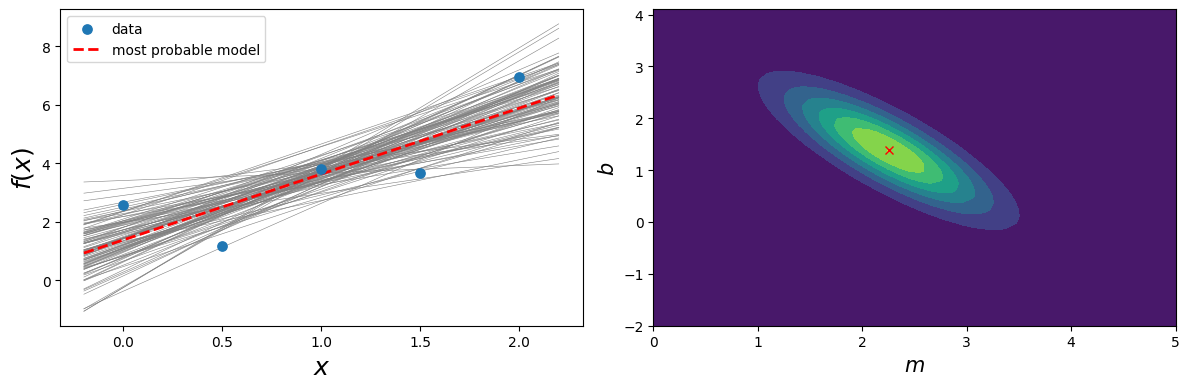

In [8]:
# generate som "True" data
from scipy.stats import multivariate_normal
x = np.linspace(0, 2, 5)
m = 2
b = 1
y = linear_model(m, b, x) + np.random.uniform(-1,
                                              2, size=x.shape)  # add some noise
X = np.column_stack((x, np.ones_like(x)))

x_grid = np.linspace(-0.2, 2.2, 100)
X_grid = np.column_stack((x_grid, np.ones_like(x_grid)))

mean, std = calculate_posterior_params(X, y)
random_theta = np.random.multivariate_normal(mean, std, 100)

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4))

ax_left.scatter(x, y, label='data', zorder=3.5, s=45)
ax_left.plot(x_grid, X_grid @ mean, c='r',
             label='most probable model', ls='--', lw=2., zorder=2.5)
for t in random_theta:
    y_pred = X_grid @ t
    ax_left.plot(x_grid, y_pred, c='grey', lw=0.4)

ax_left.legend()
ax_left.set_xlabel(r'$x$', fontsize=18)
ax_left.set_ylabel(r'$f(x)$', fontsize=18)

theta1, theta0 = np.meshgrid(
    np.linspace(-0., 5, 50), np.linspace(-2, 4.1, 50))
pos = np.empty(theta0.shape + (2,))
pos[:, :, 0] = theta1
pos[:, :, 1] = theta0

rv = multivariate_normal(mean=mean, cov=std)

ax_right.contourf(theta1, theta0, rv.pdf(pos))
ax_right.plot(mean[0], mean[1], 'rx', label='mean')
ax_right.set_xlabel(r'$m$', fontsize=15)
ax_right.set_ylabel(r'$b$', fontsize=15)

plt.tight_layout()

*   **Blue Points:** These represent the actual observed data points.
  
*   **Black Lines:** Each of these represents a regression line sampled from the posterior distribution. They give a sense of the uncertainty in the regression model; where they are dense, there is more certainty about the model, and where they spread out, there is more uncertainty.

*   **Red Dashed Line:** This is the most probable regression line based on the mean of the posterior distribution.

In [13]:
from scipy.stats import multivariate_normal

MAX_POINTS = 50
rng_data = np.random.default_rng(42)
x_all = rng_data.uniform(-1., 1., MAX_POINTS)
y_all = 2.0 * x_all + 1.0 + rng_data.normal(0., 0.3, MAX_POINTS)
X_all = np.column_stack((x_all, np.ones_like(x_all)))

def frame(n_points=10):
    X = X_all[:n_points]
    y = y_all[:n_points]

    mean, std = calculate_posterior_params(X, y)
    rng_theta = np.random.default_rng(123)
    random_theta = rng_theta.multivariate_normal(mean, std, 50)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # left panel
    x_grid = np.linspace(-1., 1., 100)
    X_grid = np.column_stack((x_grid, np.ones_like(x_grid)))
    axs[0].scatter(X[:, 0], y, label='data', zorder=3.5, s=70)
    axs[0].plot(x_grid, X_grid @ mean, c='r',
                label=r'$\mathbf{w}_{MAP}^{*}$', ls='--', lw=2., zorder=2.5)
    for t in random_theta:
        y_pred = X_grid @ t
        axs[0].plot(x_grid, y_pred, c='grey', lw=0.4)

    axs[0].legend(fontsize=15)
    axs[0].set_xlabel(r'$x$', fontsize=18)
    axs[0].set_ylabel(r'$f(x)$', fontsize=18)

    # right panel
    theta1, theta0 = np.meshgrid(
        np.linspace(-5., 5., 50), np.linspace(-5., 5., 100))
    pos = np.empty(theta0.shape + (2,))
    pos[:, :, 0] = theta1
    pos[:, :, 1] = theta0
    rv = multivariate_normal(mean=mean, cov=std)

    axs[1].contourf(theta1, theta0, rv.pdf(pos))
    axs[1].set_xlabel(r'$m$', fontsize=15)
    axs[1].set_ylabel(r'$b$', fontsize=15)

    plt.tight_layout()
    plt.show()

interact(
    frame,
    n_points=widgets.IntSlider(min=1, max=MAX_POINTS, step=1, value=1),
)


interactive(children=(IntSlider(value=1, description='n_points', max=50, min=1), Output()), _dom_classes=('wid…

<function __main__.frame(n_points=10)>